<a href="https://colab.research.google.com/github/PinRay22/BA/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== 訓練 LSTM 基線 ===
[LSTM][Epoch 01] train_loss=1.1423  val_RMSE=1.3349
[LSTM][Epoch 02] train_loss=0.9759  val_RMSE=1.2278
[LSTM][Epoch 03] train_loss=0.9465  val_RMSE=1.2247
[LSTM][Epoch 04] train_loss=0.9231  val_RMSE=1.1890
[LSTM][Epoch 05] train_loss=0.9146  val_RMSE=1.2059
[LSTM][Epoch 06] train_loss=0.9303  val_RMSE=1.1970
[LSTM][Epoch 07] train_loss=0.9226  val_RMSE=1.2169
[LSTM][Epoch 08] train_loss=0.9105  val_RMSE=1.2083
[LSTM][Epoch 09] train_loss=0.9176  val_RMSE=1.2154
[LSTM][Epoch 10] train_loss=0.9194  val_RMSE=1.2104
[LSTM][Epoch 11] train_loss=0.9080  val_RMSE=1.2271
[LSTM][Epoch 12] train_loss=0.9248  val_RMSE=1.2064
[LSTM][Epoch 13] train_loss=0.9105  val_RMSE=1.2419
[LSTM][Epoch 14] train_loss=0.9239  val_RMSE=1.2264
[LSTM][Epoch 15] train_loss=0.9094  val_RMSE=1.2512
[LSTM][Epoch 16] train_loss=0.9222  val_RMSE=1.2086
[LSTM][Epoch 17] train_loss=0.8918  val_RMSE=1.2325
[LSTM][Epoch 18] train_loss=0.8995  val_RMSE=1.2211
[LSTM][Epoch 19] train_loss=0.9237  val_RMSE=

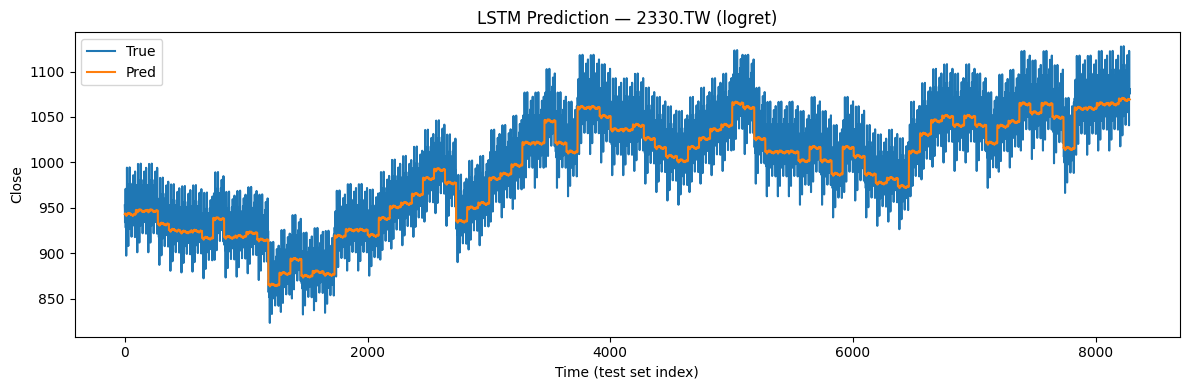

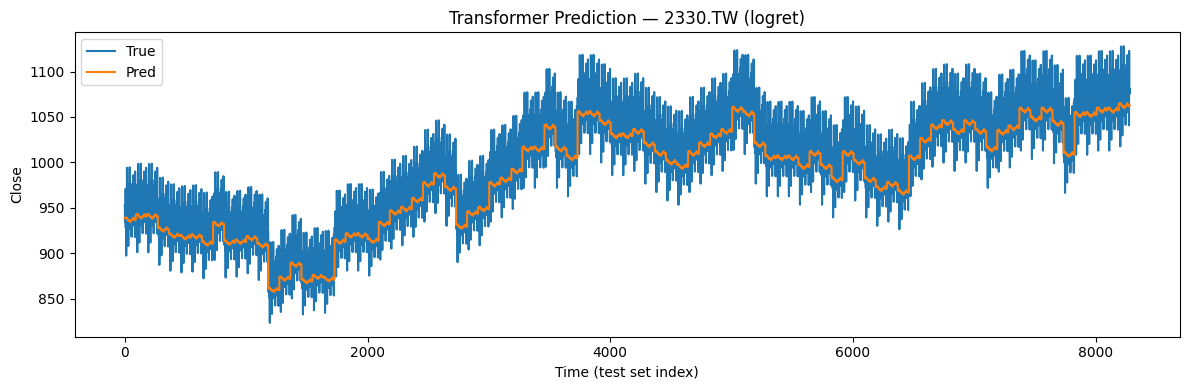

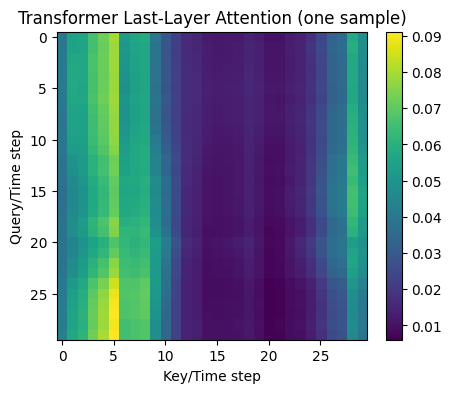


==================== SUMMARY ====================
TICKER: 2330.TW, Period: 2020-01-01 ~ 2024-12-31, TARGET_MODE=logret
Lookback: 30, Features: 11
Train/Val/Test size (rows): 955 / 119 / 120

LSTM TEST (std):       MSE=1.251958  MAE=0.856959  RMSE=1.118909
LSTM TEST (original):  MSE=373.8933  MAE=14.7454  RMSE=19.3363

TR  TEST (std):        MSE=1.676555  MAE=1.019873  RMSE=1.294818
TR  TEST (original):   MSE=499.8056  MAE=17.5178  RMSE=22.3563



In [ ]:
# ===========================================
# HW4 — Transformer for Stock Price Prediction (Colab-ready, with patches)
# - 支援 TARGET_MODE: "price" 或 "logret"
# - 會同時輸出「標準化空間」與「原始價格尺度」的評估指標
# ===========================================
!pip -q install yfinance

import os, math, random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# 可調參數
# -------------------------------
TICKER = "2330.TW"        # e.g., "AAPL", "TSLA", "MSFT", "2330.TW"
START  = "2020-01-01"
END    = "2024-12-31"

LOOKBACK   = 30
BATCH_SIZE = 64
EPOCHS     = 30
SEED       = 42
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# 預測目標模式: "price"（預測下一日收盤價）或 "logret"（預測對數報酬，推薦）
TARGET_MODE = "logret"  # "price" / "logret"

# LSTM 超參數
LSTM_HIDDEN = 128
LSTM_LAYERS = 1
LSTM_DROPOUT = 0.1

# Transformer 超參數
D_MODEL = 128
N_HEADS = 4
FFN_HIDDEN = 256
N_LAYERS = 2
DROPOUT = 0.1
LR = 1e-4

# -------------------------------
# 重現性
# -------------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# -------------------------------
# 技術指標
# -------------------------------
def add_tech_indicators(df: pd.DataFrame) -> pd.DataFrame:
    close = df["Close"]

    # SMA
    df["SMA_5"]  = close.rolling(5).mean()
    df["SMA_20"] = close.rolling(20).mean()

    # RSI 14
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    roll_up = gain.rolling(14).mean()
    roll_down = loss.rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    df["RSI_14"] = 100.0 - (100.0 / (1.0 + RS))

    # MACD
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    hist = macd - signal
    df["MACD"] = macd
    df["MACD_SIGNAL"] = signal
    df["MACD_HIST"] = hist
    return df

# -------------------------------
# 下載 & 特徵
# -------------------------------
raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if len(raw) < 300:
    raise ValueError("資料筆數過少，請調整日期或更換 TICKER。")

df = raw.copy()
df = add_tech_indicators(df)
df.dropna(inplace=True)  # 移除技術指標起始的 NaN

# 設定預測目標
if TARGET_MODE == "price":
    # 目標：下一日收盤價
    df["Target"] = df["Close"].shift(-1)
elif TARGET_MODE == "logret":
    # 目標：下一日對數報酬
    df["Target"] = np.log(df["Close"].shift(-1)) - np.log(df["Close"])
else:
    raise ValueError("TARGET_MODE 必須是 'price' 或 'logret'")
df.dropna(inplace=True)

FEATURE_COLS = ["Open","High","Low","Close","Volume",
                "SMA_5","SMA_20","RSI_14","MACD","MACD_SIGNAL","MACD_HIST"]
TARGET_COL = "Target"

# -------------------------------
# 時序切分（8:1:1）
# -------------------------------
n = len(df)
train_end = int(n * 0.8)
val_end   = int(n * 0.9)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

# 僅用 train fit scaler，避免洩漏
scaler_x = StandardScaler().fit(df_train[FEATURE_COLS].values)
scaler_y = StandardScaler().fit(df_train[[TARGET_COL]].values)

def scale_xy(d):
    X = scaler_x.transform(d[FEATURE_COLS].values)
    y = scaler_y.transform(d[[TARGET_COL]].values).ravel()
    return X, y

X_train_raw, y_train_raw = scale_xy(df_train)
X_val_raw,   y_val_raw   = scale_xy(df_val)
X_test_raw,  y_test_raw  = scale_xy(df_test)

# 原始 close（未標準化），供還原用
close_test_raw = df_test["Close"].values

# -------------------------------
# 序列資料集
# -------------------------------
class SeqDataset(Dataset):
    def __init__(self, X, y, lookback):
        self.X = X; self.y = y; self.lb = lookback
        self.n = len(X) - lookback + 1
        if self.n <= 0:
            raise ValueError("樣本太少，請縮短 lookback 或增加資料。")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.lb]               # [lb, feat]
        y_tgt = self.y[idx+self.lb-1]                 # 對應序列最後一天
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_tgt, dtype=torch.float32)

train_ds = SeqDataset(X_train_raw, y_train_raw, LOOKBACK)
val_ds   = SeqDataset(X_val_raw,   y_val_raw,   LOOKBACK)
test_ds  = SeqDataset(X_test_raw,  y_test_raw,  LOOKBACK)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

N_FEATURES = len(FEATURE_COLS)

# -------------------------------
# LSTM 基線
# -------------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=128, layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=layers, batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Sequential(nn.LayerNorm(hidden), nn.Linear(hidden, 1))

    def forward(self, x):
        out, _ = self.lstm(x)       # [B,T,H]
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

# -------------------------------
# Positional Encoding
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        pe = pe.unsqueeze(0)  # [1,T,D]
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

# -------------------------------
# Encoder Layer (回傳注意力)
# -------------------------------
class EncoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, nhead, dim_ff=256, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_ff)
        self.linear2 = nn.Linear(dim_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.act = nn.GELU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None, need_weights=False):
        attn_out, attn_weights = self.self_attn(
            src, src, src, attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask, need_weights=True
        )
        src = self.norm1(src + self.dropout1(attn_out))
        ff = self.linear2(self.dropout(self.act(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        if need_weights:
            return src, attn_weights
        return src, None

# -------------------------------
# Transformer Regressor
# -------------------------------
class TransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayerWithAttn(d_model, nhead, dim_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x, return_last_attn=False):
        x = self.input_proj(x)
        x = self.pos(x)
        attn_last = None
        for i, layer in enumerate(self.layers):
            x, attn = layer(x, need_weights=return_last_attn and (i == len(self.layers)-1))
            if attn is not None:
                attn_last = attn
        x = self.norm(x)
        pooled = x.mean(dim=1)                       # 對時間維做平均
        yhat = self.head(pooled).squeeze(-1)
        if return_last_attn:
            return yhat, attn_last
        return yhat


# -------------------------------
# 訓練與驗證
# -------------------------------
def train_one_epoch(model, loader, opt, crit):
    model.train(); total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        opt.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval(); total = 0.0
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        pred = model(xb)
        loss = crit(pred, yb)
        total += loss.item() * xb.size(0)
        preds.append(pred.detach().cpu().numpy())
        trues.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = math.sqrt(mse)
    return total / len(loader.dataset), (mse, mae, rmse), preds, trues

def denorm_y(y_scaled):
    y_scaled = np.asarray(y_scaled).reshape(-1,1)
    return scaler_y.inverse_transform(y_scaled).ravel()

# 為 logret 模式建立 base close（每個樣本的最後一天 Close[t]），供還原 t+1 價格
def make_base_close_series(df_block, lookback):
    closes = df_block["Close"].values  # 未標準化
    bases = []
    for i in range(len(closes) - lookback + 1):
        bases.append(closes[i + lookback - 1])  # 每個樣本最後一天 Close[t]
    return np.array(bases)

def rebuild_from_logret(logret_arr, base_close):
    return base_close * np.exp(logret_arr)

# 視覺化
def plot_pred(y_true, y_pred, title):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    x = np.arange(len(y_true))

    plt.figure(figsize=(12,4))
    plt.plot(x, y_true, label="True")
    plt.plot(x, y_pred, label="Pred")

    # 圖例去重，避免重覆顯示
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(title)
    plt.xlabel("Time (test set index)")
    plt.ylabel("Close")
    plt.tight_layout()
    plt.show()

class WarmupWrapper:
    def __init__(self, optimizer, base_scheduler, warmup_steps, base_lr):
        self.optimizer = optimizer
        self.base_scheduler = base_scheduler
        self.warmup_steps = warmup_steps
        self.base_lr = base_lr
        self._step = 0

    def step(self):
        self._step += 1
        if self._step <= self.warmup_steps:
            scale = self._step / max(1, self.warmup_steps)
            for pg in self.optimizer.param_groups:
                pg['lr'] = self.base_lr * scale
        else:
            self.base_scheduler.step()

    def get_last_lr(self):
        return [pg['lr'] for pg in self.optimizer.param_groups]


# -------------------------------
# 1) LSTM
# -------------------------------
lstm = LSTMRegressor(N_FEATURES, hidden=LSTM_HIDDEN, layers=LSTM_LAYERS, dropout=LSTM_DROPOUT).to(DEVICE)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=LR)
crit = nn.MSELoss()

best_val = float('inf'); best_state_lstm = None
print("=== 訓練 LSTM 基線 ===")
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch(lstm, train_loader, opt_lstm, crit)
    va, (mse_v, mae_v, rmse_v), _, _ = evaluate(lstm, val_loader, crit)
    print(f"[LSTM][Epoch {ep:02d}] train_loss={tr:.4f}  val_RMSE={rmse_v:.4f}")
    if rmse_v < best_val:
        best_val = rmse_v; best_state_lstm = lstm.state_dict()
lstm.load_state_dict(best_state_lstm)

# 測試評估（標準化空間）
_, (mse_l, mae_l, rmse_l), preds_l, trues_l = evaluate(lstm, test_loader, crit)

# 轉成原始價格尺度
if TARGET_MODE == "price":
    preds_l_price = denorm_y(preds_l)   # 變回「價格」
    trues_l_price = denorm_y(trues_l)
elif TARGET_MODE == "logret":
    preds_l_logret = denorm_y(preds_l)  # 變回「對數報酬」
    trues_l_logret = denorm_y(trues_l)
    base_close_test = make_base_close_series(df_test, LOOKBACK)
    preds_l_price = rebuild_from_logret(preds_l_logret, base_close_test)
    trues_l_price = rebuild_from_logret(trues_l_logret, base_close_test)

mse_l_real  = mean_squared_error(trues_l_price, preds_l_price)
mae_l_real  = mean_absolute_error(trues_l_price, preds_l_price)
rmse_l_real = math.sqrt(mse_l_real)

print(f"\n[LSTM][TEST] (standardized) MSE={mse_l:.6f}  MAE={mae_l:.6f}  RMSE={rmse_l:.6f}")
print(f"[LSTM][TEST] (original)     MSE={mse_l_real:.4f}  MAE={mae_l_real:.4f}  RMSE={rmse_l_real:.4f}")

# -------------------------------
# 2) Transformer
# -------------------------------
transf = TransformerRegressor(N_FEATURES, d_model=D_MODEL, nhead=N_HEADS,
                              num_layers=N_LAYERS, dim_ff=FFN_HIDDEN, dropout=DROPOUT).to(DEVICE)
LR = 3e-4  # 建議把頂端參數也改成 3e-4
opt_tr = torch.optim.AdamW(transf.parameters(), lr=LR, weight_decay=1e-4)
cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt_tr, T_0=10, T_mult=1)
warmup_steps = max(5, int(0.1 * EPOCHS))  # 前 10% epoch 當 warmup
sched_tr = WarmupWrapper(opt_tr, cosine, warmup_steps, LR)


best_val = float('inf'); best_state_tr = None
print("\n=== 訓練 Transformer ===")
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch(transf, train_loader, opt_tr, crit)
    va, (mse_v, mae_v, rmse_v), _, _ = evaluate(transf, val_loader, crit)
    sched_tr.step()  # 更新學習率（含 warmup + cosine）
    print(f"[TR][Epoch {ep:02d}] train_loss={tr:.4f}  val_RMSE={rmse_v:.4f}  lr={sched_tr.get_last_lr()[0]:.2e}")
    if rmse_v < best_val:
        best_val = rmse_v; best_state_tr = transf.state_dict()

transf.load_state_dict(best_state_tr)

# 測試評估（標準化空間）
_, (mse_t, mae_t, rmse_t), preds_t, trues_t = evaluate(transf, test_loader, crit)

# 轉成原始價格尺度
if TARGET_MODE == "price":
    preds_t_price = denorm_y(preds_t)
    trues_t_price = denorm_y(trues_t)
elif TARGET_MODE == "logret":
    preds_t_logret = denorm_y(preds_t)
    trues_t_logret = denorm_y(trues_t)
    base_close_test = make_base_close_series(df_test, LOOKBACK)
    preds_t_price = rebuild_from_logret(preds_t_logret, base_close_test)
    trues_t_price = rebuild_from_logret(trues_t_logret, base_close_test)

mse_t_real  = mean_squared_error(trues_t_price, preds_t_price)
mae_t_real  = mean_absolute_error(trues_t_price, preds_t_price)
rmse_t_real = math.sqrt(mse_t_real)

print(f"\n[Transformer][TEST] (standardized) MSE={mse_t:.6f}  MAE={mae_t:.6f}  RMSE={rmse_t:.6f}")
print(f"[Transformer][TEST] (original)     MSE={mse_t_real:.4f}  MAE={mae_t_real:.4f}  RMSE={rmse_t_real:.4f}")

# -------------------------------
# 視覺化：實際 vs. 預測（原始價格尺度）
# -------------------------------
plot_pred(trues_l_price, preds_l_price, f"LSTM Prediction — {TICKER} ({TARGET_MODE})")
plot_pred(trues_t_price, preds_t_price, f"Transformer Prediction — {TICKER} ({TARGET_MODE})")

# -------------------------------
# 注意力熱圖（最後一層）
# -------------------------------
@torch.no_grad()
def get_last_attn_sample(model: TransformerRegressor, loader):
    model.eval()
    for xb, _ in loader:
        xb = xb.to(DEVICE)
        _, attn = model(xb, return_last_attn=True)  # [B, heads?, T, T] or [B,T,T] (這裡 MultiheadAttention 回 [B, T, T] 但已平均 head)
        if attn is not None:
            return attn[0].detach().cpu().numpy()
    return None

attn_mat = get_last_attn_sample(transf, test_loader)
if attn_mat is not None:
    plt.figure(figsize=(5,4))
    plt.imshow(attn_mat, aspect='auto', interpolation='nearest')
    plt.title("Transformer Last-Layer Attention (one sample)")
    plt.xlabel("Key/Time step"); plt.ylabel("Query/Time step")
    plt.colorbar(); plt.show()
else:
    print("無法擷取注意力權重。")

# -------------------------------
# 總結
# -------------------------------
def summary_print():
    print("\n==================== SUMMARY ====================")
    print(f"TICKER: {TICKER}, Period: {START} ~ {END}, TARGET_MODE={TARGET_MODE}")
    print(f"Lookback: {LOOKBACK}, Features: {N_FEATURES}")
    print(f"Train/Val/Test size (rows): {len(df_train)} / {len(df_val)} / {len(df_test)}")
    print("\nLSTM TEST (std):       MSE={:.6f}  MAE={:.6f}  RMSE={:.6f}".format(mse_l, mae_l, rmse_l))
    print("LSTM TEST (original):  MSE={:.4f}  MAE={:.4f}  RMSE={:.4f}".format(mse_l_real, mae_l_real, rmse_l_real))
    print("\nTR  TEST (std):        MSE={:.6f}  MAE={:.6f}  RMSE={:.6f}".format(mse_t, mae_t, rmse_t))
    print("TR  TEST (original):   MSE={:.4f}  MAE={:.4f}  RMSE={:.4f}".format(mse_t_real, mae_t_real, rmse_t_real))
    print("=================================================\n")

summary_print()
